In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [8]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

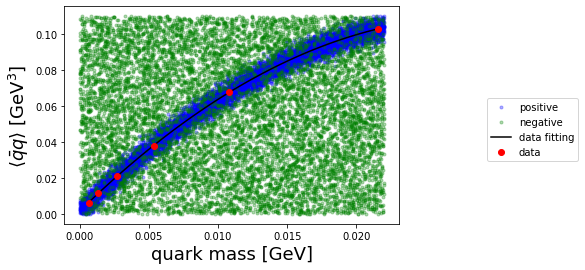

In [9]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [10]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [51]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [131]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss1(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output*(2-answer), answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss
    def loss2(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss
def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [165]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1,  1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
print("H: ", np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
H:  [-1.9115444  6.2469516  4.4072027  5.6907644  5.0146294  5.650589
  1.2188298  2.9316332  6.7014046  3.9752748  7.2526073  4.3918896
  1.3041756  5.8820343  6.1965714]


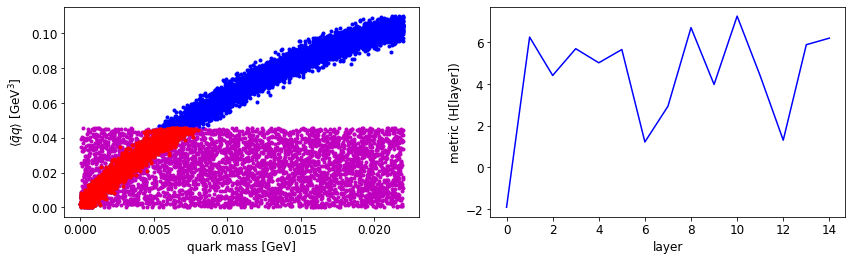

In [166]:
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [161]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='NN(positive)=/=0')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

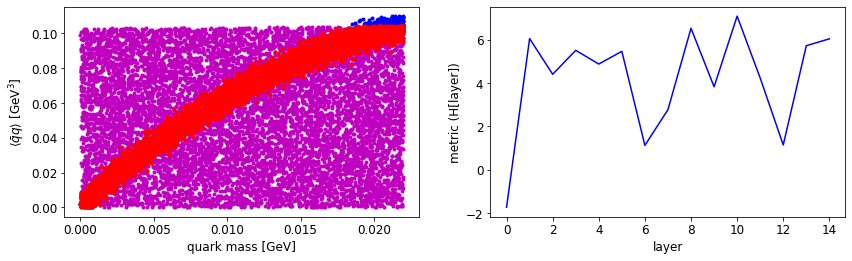

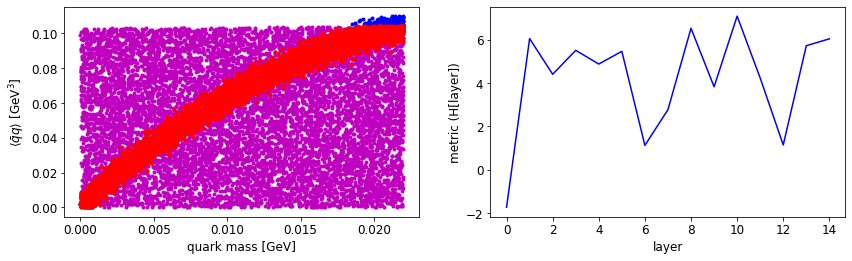

training epoch: 0,   loss: 1.6385910511016846
lambda: 0.027608660981059074,   AdS radius: 0.6318064332008362[1/GeV]
[-1.7277175  6.046082   4.401634   5.5049453  4.872588   5.459696
  1.1239339  2.7724512  6.5205193  3.8262281  7.0818877  4.230331
  1.1435146  5.71876    6.0344205]


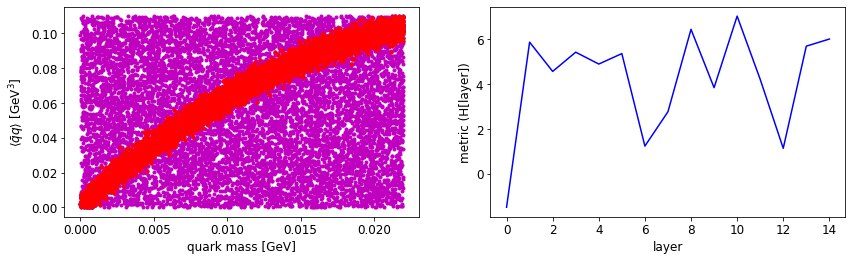

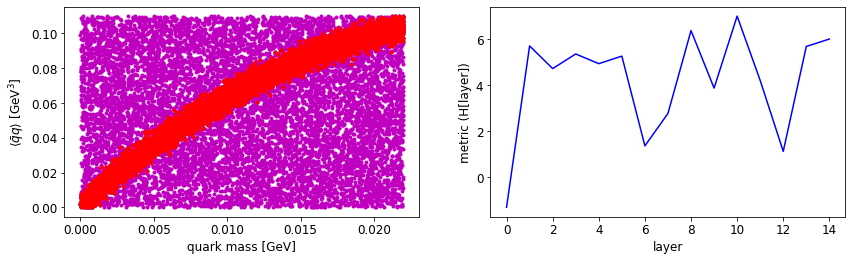

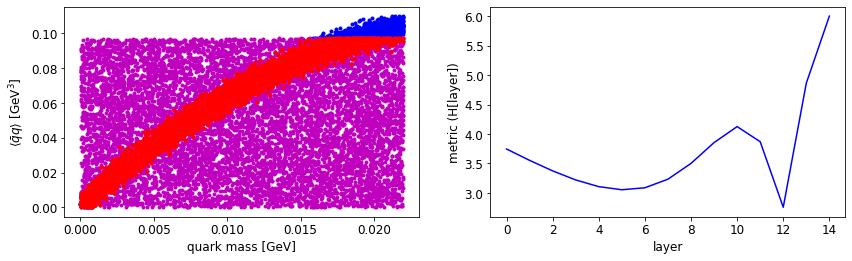

training epoch: 100,   loss: 0.2521989941596985
lambda: -4.009414196014404,   AdS radius: 0.7288375496864319[1/GeV]
[3.7459695 3.5527823 3.3739347 3.2201211 3.1064994 3.0537152 3.0873675
 3.232977  3.501512  3.855051  4.1262875 3.8699465 2.7566297 4.8640037
 6.00299  ]


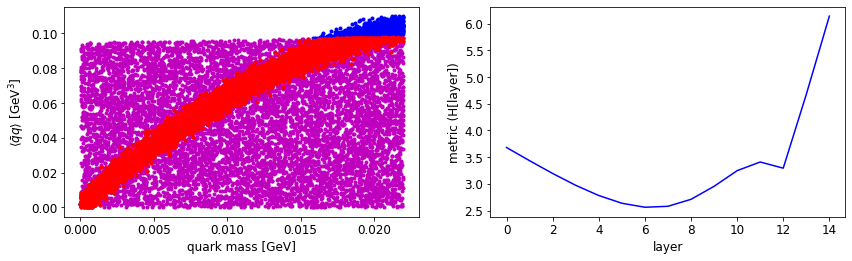

training epoch: 200,   loss: 0.2497551590204239
lambda: -8.08211898803711,   AdS radius: 0.8414511680603027[1/GeV]
[3.6799142 3.4329882 3.194122  2.9725878 2.7812414 2.6372154 2.5619621
 2.5795572 2.7103581 2.953518  3.2467816 3.4087265 3.2935574 4.67515
 6.139677 ]


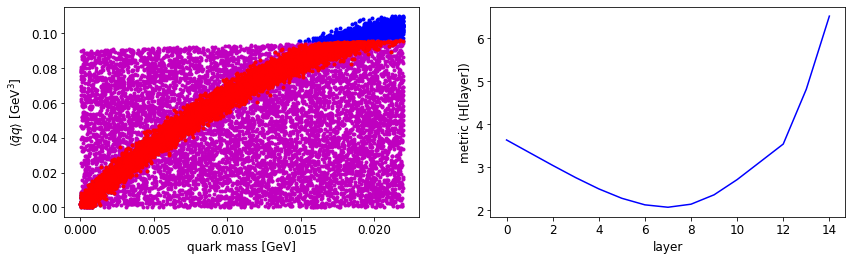

training epoch: 300,   loss: 0.24847561120986938
lambda: -11.876826286315918,   AdS radius: 0.9573808908462524[1/GeV]
[3.6298888 3.333194  3.0373106 2.7515168 2.489388  2.2697506 2.1171658
 2.0611198 2.1321287 2.3509567 2.7054172 3.1193805 3.5345428 4.8129325
 6.517045 ]


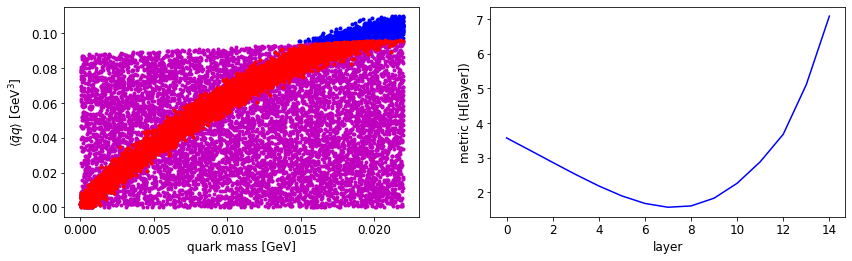

training epoch: 400,   loss: 0.24599558115005493
lambda: -15.458117485046387,   AdS radius: 1.101183533668518[1/GeV]
[3.5667796 3.2158704 2.860062  2.5094573 2.1793025 1.8911507 1.6738455
 1.5635084 1.6011491 1.82536   2.256622  2.8768957 3.6735187 5.1086335
 7.0890613]


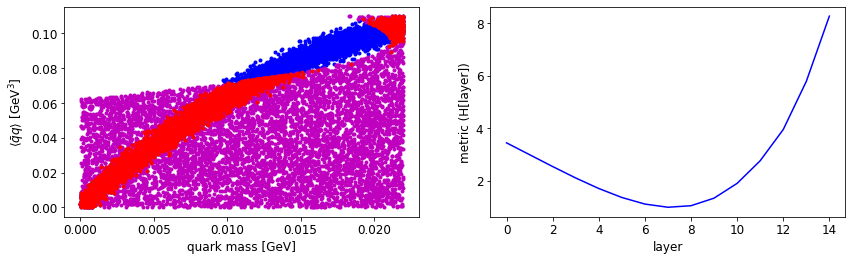

training epoch: 500,   loss: 0.23225674033164978
lambda: -18.154375076293945,   AdS radius: 1.5698643922805786[1/GeV]
[3.4361029  2.9843984  2.5326462  2.096341   1.6950413  1.3530084
 1.1014137  0.98040384 1.0384673  1.3274624  1.8916068  2.7535746
 3.943499   5.7797008  8.269132  ]


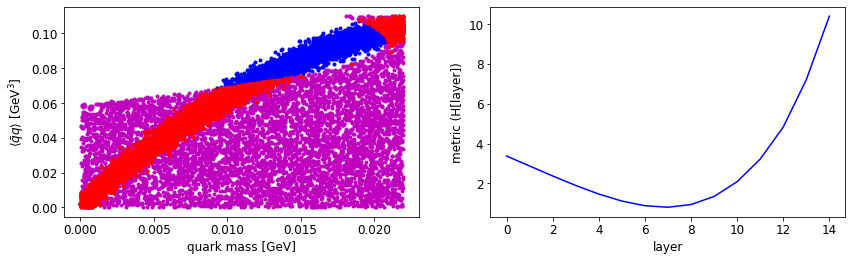

training epoch: 600,   loss: 0.2265206277370453
lambda: -18.09880256652832,   AdS radius: 1.5654608011245728[1/GeV]
[ 3.3775258   2.8762596   2.3770661   1.8997283   1.4699984   1.1193311
  0.8845808   0.80887187  0.9437143   1.3492725   2.0889552   3.2219558
  4.8292274   7.2044115  10.391431  ]


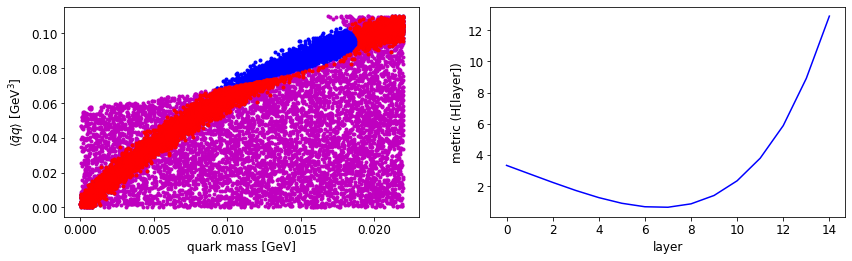

training epoch: 700,   loss: 0.2196280062198639
lambda: -17.93478012084961,   AdS radius: 1.552665114402771[1/GeV]
[ 3.3177283   2.7696638   2.2246063   1.7062297   1.2458041   0.8817031
  0.65849507  0.62674016  0.84502137  1.3838305   2.3280056   3.778186
  5.8746843   8.90948    12.913994  ]


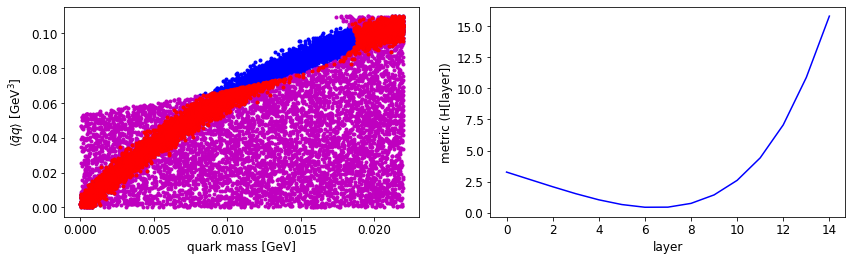

training epoch: 800,   loss: 0.2119911164045334
lambda: -17.618236541748047,   AdS radius: 1.5319592952728271[1/GeV]
[ 3.2727048   2.6834998   2.0961342   1.5378882   1.0454162   0.66430306
  0.44774398  0.45583594  0.7577437   1.4383262   2.607921    4.414313
  7.065782   10.872687   15.804452  ]


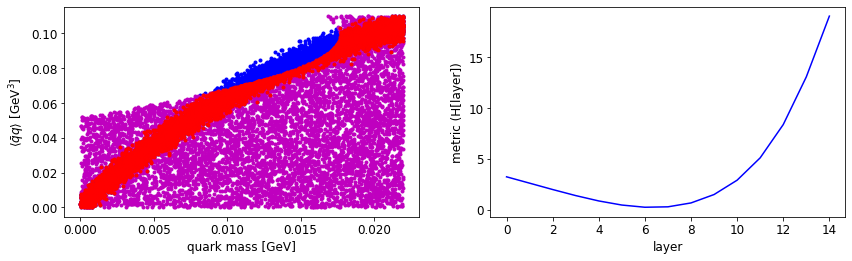

training epoch: 900,   loss: 0.2040865272283554
lambda: -17.13143539428711,   AdS radius: 1.5040934085845947[1/GeV]
[ 3.2344275   2.6117458   1.9873968   1.3916088   0.8661312   0.46401048
  0.2480308   0.28957677  0.67117894  1.4959586   2.9047127   5.09869
  8.362876   13.043892   19.009518  ]


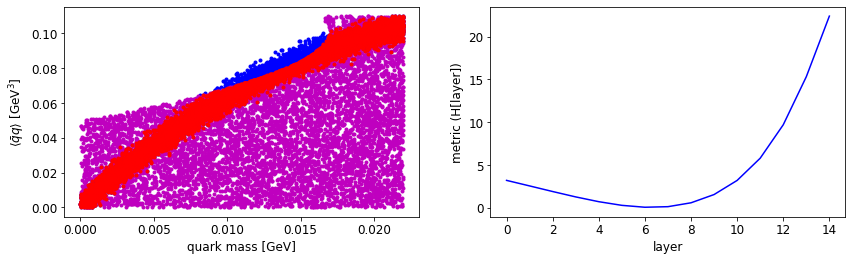

training epoch: 1000,   loss: 0.1972811371088028
lambda: -16.462297439575195,   AdS radius: 1.4765205383300781[1/GeV]
[ 3.2087908   2.5612712   1.9067833   1.2775434   0.71962196  0.29325023
  0.07129456  0.13774954  0.59058595  1.5540429   3.202989    5.7960935
  9.69957    15.311909   22.388786  ]


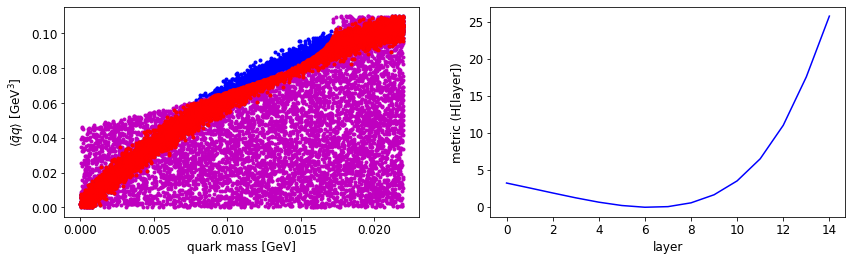

training epoch: 1100,   loss: 0.19169101119041443
lambda: -15.61452865600586,   AdS radius: 1.458669662475586[1/GeV]
[ 3.1973827e+00  2.5328624e+00  1.8553314e+00  1.1979014e+00
  6.0980970e-01  1.5763193e-01 -7.5832419e-02  6.7027416e-03
  5.1996583e-01  1.6109051e+00  3.4896305e+00  6.4717965e+00
  1.1002156e+01  1.7542768e+01  2.5766115e+01]


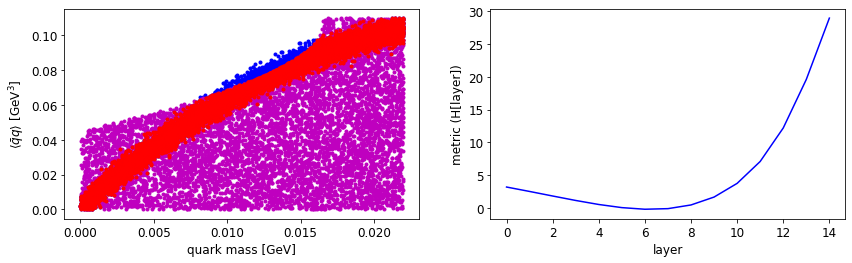

training epoch: 1200,   loss: 0.18756115436553955
lambda: -14.611804962158203,   AdS radius: 1.4329088926315308[1/GeV]
[ 3.1859574   2.510383    1.8159257   1.1358049   0.5212388   0.0439024
 -0.20431569 -0.11290392  0.45015663  1.6549108   3.7455797   7.089625
 12.20074    19.611628   28.972319  ]


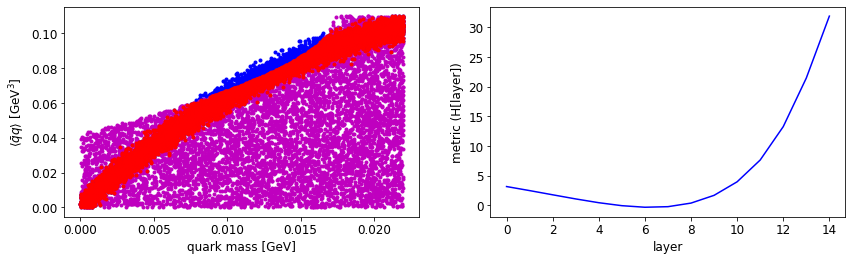

training epoch: 1300,   loss: 0.18420197069644928
lambda: -13.444397926330566,   AdS radius: 1.4179141521453857[1/GeV]
[ 3.1835337   2.5003896   1.7935749   1.0957069   0.45898092 -0.0411294
 -0.30485    -0.20912606  0.3952031   1.7007978   3.9832833   7.6535907
 13.280253   21.46678    31.905693  ]


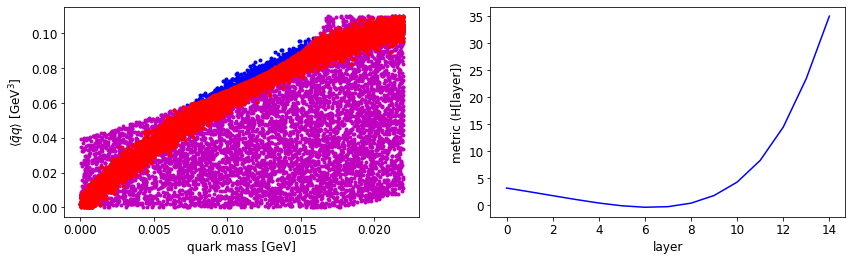

training epoch: 1400,   loss: 0.1804257333278656
lambda: -11.942440032958984,   AdS radius: 1.416466236114502[1/GeV]
[ 3.1595035   2.4641914   1.7473257   1.0385187   0.3885279  -0.12538442
 -0.3969399  -0.29099464  0.35953093  1.7718884   4.255787    8.268668
 14.436665   23.430176   34.97649   ]


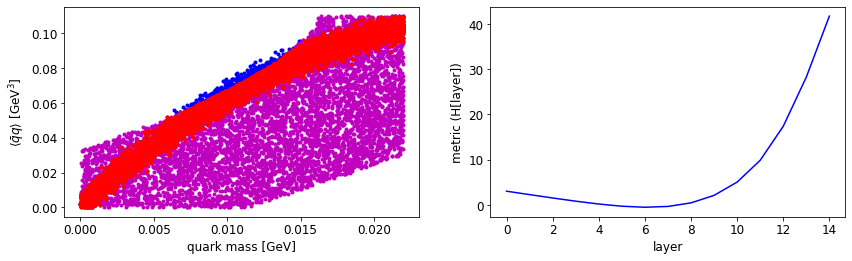

training epoch: 1500,   loss: 0.1613946408033371
lambda: -8.231683731079102,   AdS radius: 1.4296534061431885[1/GeV]
[ 3.0353343   2.2775643   1.5336541   0.82648844  0.19615676 -0.28696814
 -0.51352215 -0.33274198  0.45288116  2.1129746   5.048861    9.871016
 17.388578   28.26461    41.758156  ]


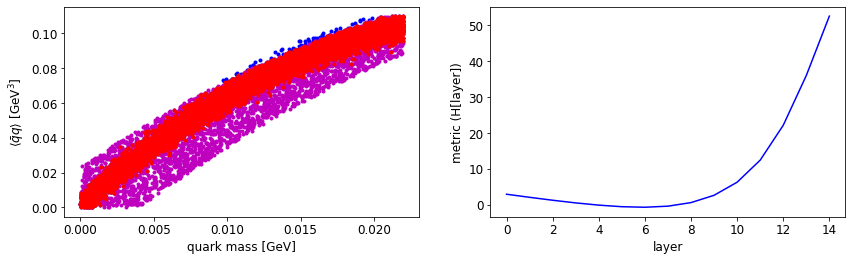

training epoch: 1600,   loss: 0.09485593438148499
lambda: 0.20152628421783447,   AdS radius: 2.152897596359253[1/GeV]
[ 2.891776    2.0319273   1.2145493   0.47482738 -0.14609094 -0.5847448
 -0.73502445 -0.4328835   0.5594087   2.5960205   6.244776   12.395729
 22.11904    35.996338   52.555614  ]


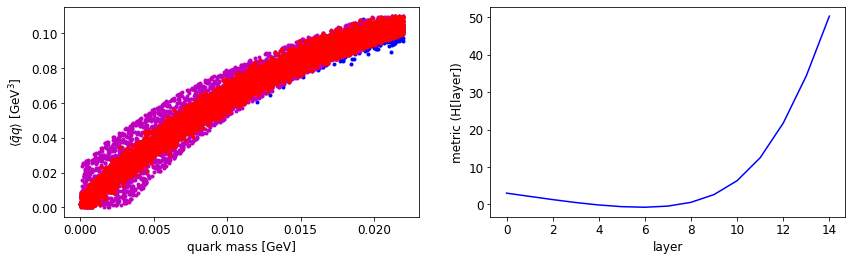

training epoch: 1700,   loss: 0.08082567155361176
lambda: 0.018918439745903015,   AdS radius: 3.1017606258392334[1/GeV]
[ 2.965149    2.0977862   1.2371875   0.45094284 -0.20243654 -0.65731764
 -0.81158125 -0.503343    0.50864136  2.5870576   6.2993965  12.444725
 21.718721   34.368145   50.360943  ]


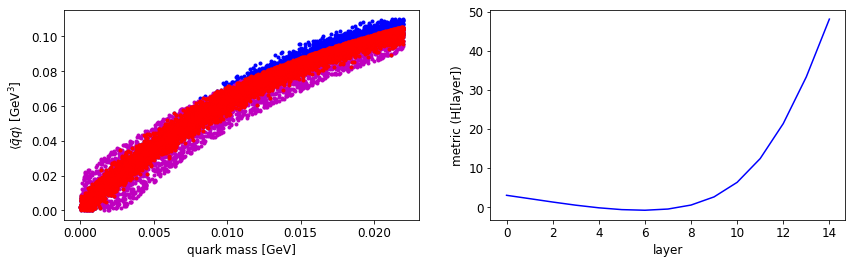

training epoch: 1800,   loss: 0.07803128659725189
lambda: 0.008190165273845196,   AdS radius: 3.497013568878174[1/GeV]
[ 2.990864    2.134633    1.2676075   0.46224958 -0.20963326 -0.6757493
 -0.8344758  -0.52559173  0.49261975  2.5842528   6.3067865  12.387781
 21.34059    33.295605   48.085342  ]


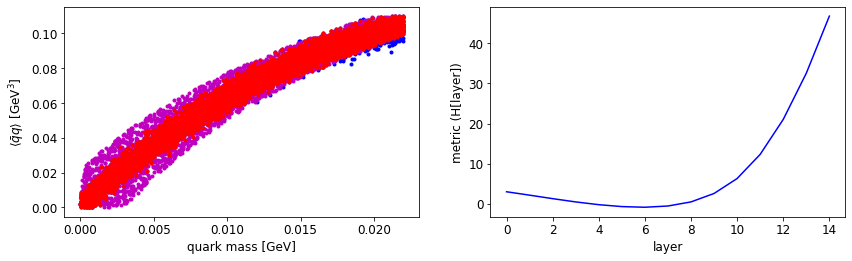

training epoch: 1900,   loss: 0.07725001871585846
lambda: 0.004813297651708126,   AdS radius: 3.63287615776062[1/GeV]
[ 3.0050552   2.15734     1.2892959   0.47264296 -0.21310304 -0.68876547
 -0.8516699  -0.5427438   0.4797194   2.5799873   6.3047576  12.32308
 21.0326     32.535378   46.76466   ]


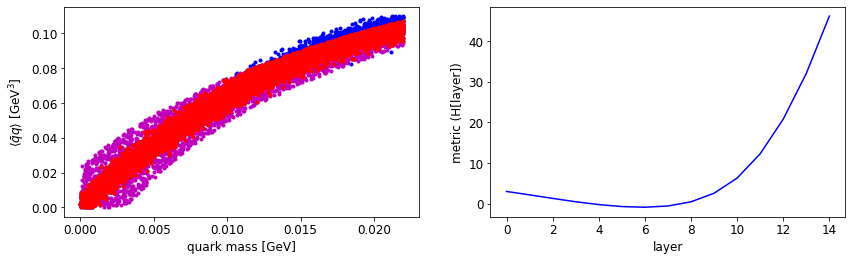

training epoch: 2000,   loss: 0.07695238292217255
lambda: 0.006139085162431002,   AdS radius: 3.6681320667266846[1/GeV]
[ 3.0159054   2.1754258   1.3082321   0.48378345 -0.21365286 -0.6982716
 -0.8652794  -0.55630744  0.470227    2.5783296   6.303691   12.264591
 20.784002   32.012505   46.087376  ]


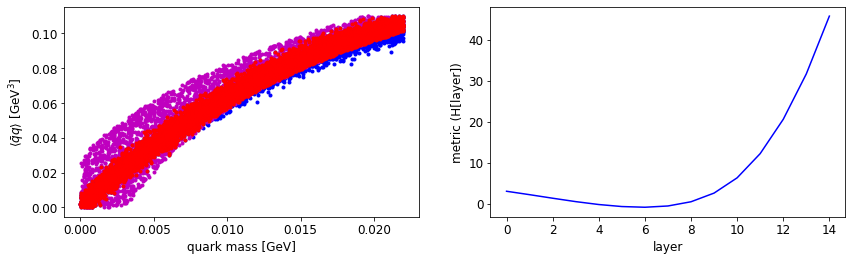

training epoch: 2100,   loss: 0.07569615542888641
lambda: 0.005549358669668436,   AdS radius: 3.672271966934204[1/GeV]
[ 3.022706    2.1882954   1.322725    0.49272808 -0.21470526 -0.7077964
 -0.87887836 -0.56981945  0.4607901   2.5764124   6.3017626  12.21131
 20.584589   31.663115   45.77239   ]


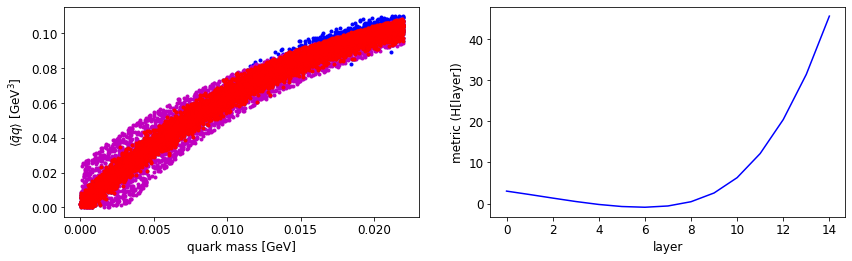

training epoch: 2200,   loss: 0.07608315348625183
lambda: 0.005730100907385349,   AdS radius: 3.684058904647827[1/GeV]
[ 3.0318108   2.2026463   1.3389567   0.5047405  -0.21164131 -0.7130829
 -0.8884611  -0.5794471   0.45518005  2.5779388   6.3021317  12.162815
 20.415873   31.399902   45.552696  ]


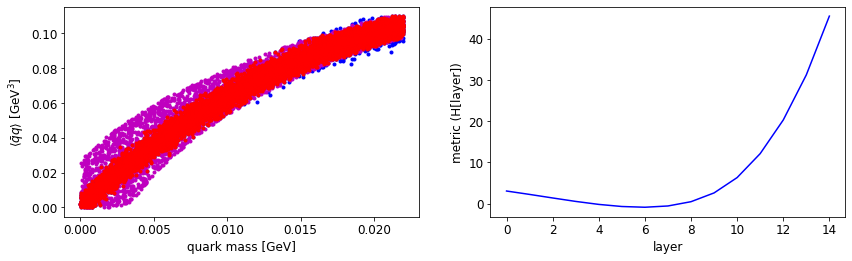

training epoch: 2300,   loss: 0.07568610459566116
lambda: 0.005513499956578016,   AdS radius: 3.6984455585479736[1/GeV]
[ 3.0370696   2.2126071   1.351015    0.51359415 -0.21078622 -0.7204025
 -0.90024734 -0.59130865  0.44746828  2.5773594   6.299993   12.116059
 20.275112   31.220392   45.492596  ]


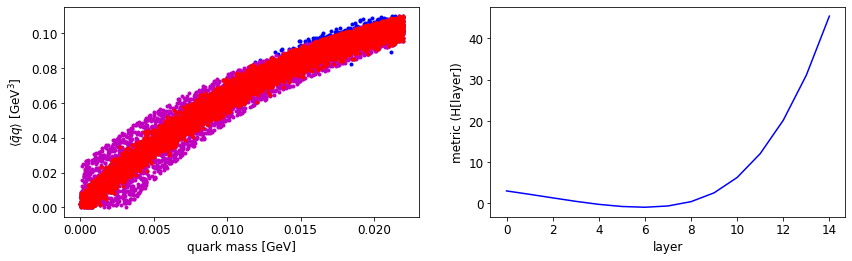

training epoch: 2400,   loss: 0.0756009966135025
lambda: 0.00487830163910985,   AdS radius: 3.7074577808380127[1/GeV]
[ 3.0440376   2.2237067   1.3641359   0.52431023 -0.20703995 -0.7244111
 -0.9088109  -0.6001291   0.44252384  2.578856    6.2988734  12.073653
 20.156204   31.075916   45.407673  ]


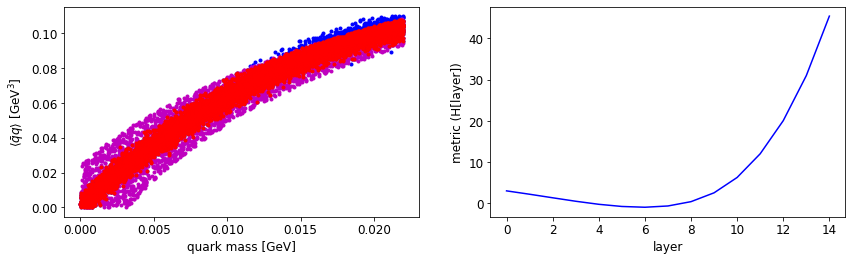

training epoch: 2500,   loss: 0.07561939209699631
lambda: 0.005581734236329794,   AdS radius: 3.686244487762451[1/GeV]
[ 3.0487287   2.2321491   1.3746545   0.53310114 -0.20427649 -0.72889966
 -0.91782975 -0.60949016  0.43692574  2.5793118   6.2963514  12.03433
 20.057346   30.971064   45.389526  ]


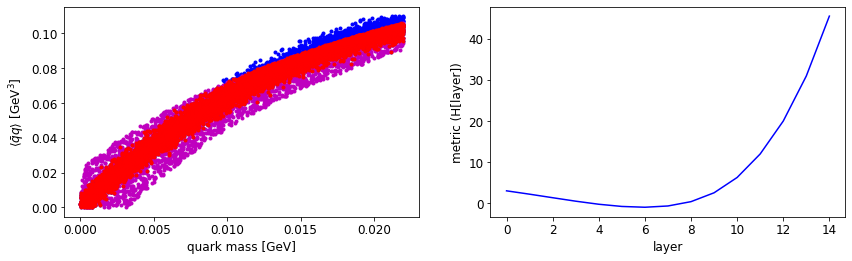

training epoch: 2600,   loss: 0.07592999935150146
lambda: 0.005129271652549505,   AdS radius: 3.716982364654541[1/GeV]
[ 3.053992    2.2407901   1.3852913   0.54232794 -0.2006597  -0.7325063
 -0.9262295  -0.61835694  0.43193457  2.580419    6.294314   11.998531
 19.975672   30.90646    45.434856  ]


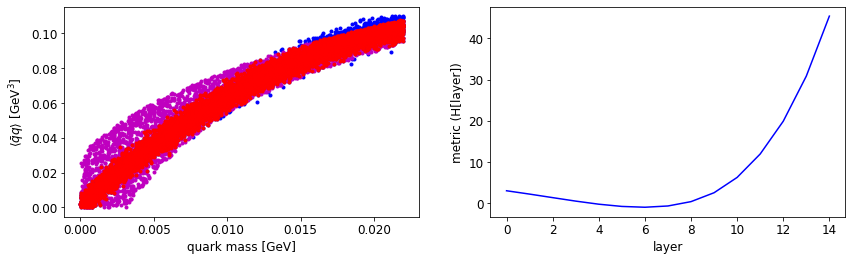

training epoch: 2700,   loss: 0.07497085630893707
lambda: 0.006626428570598364,   AdS radius: 3.7271828651428223[1/GeV]
[ 3.0553777   2.2452626   1.3916308   0.5475759  -0.20035209 -0.7389971
 -0.93754023 -0.6303821   0.42336133  2.577084    6.286742   11.959152
 19.895359   30.824434   45.35943   ]


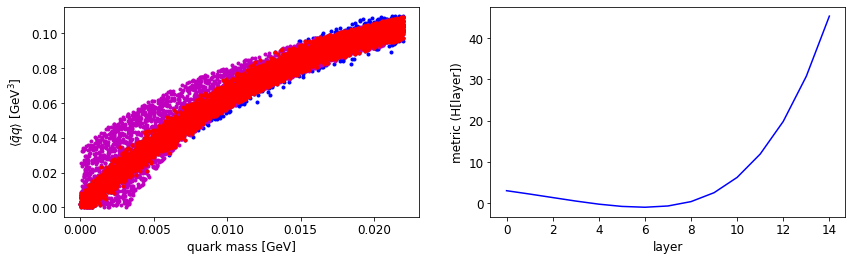

training epoch: 2800,   loss: 0.07672777026891708
lambda: 0.007117201574146748,   AdS radius: 3.692782402038574[1/GeV]
[ 3.058516    2.251322    1.3995465   0.5547798  -0.19738883 -0.742271
 -0.9454892  -0.6391543   0.41778862  2.5762167   6.2814274  11.925352
 19.828268   30.75642    45.31914   ]


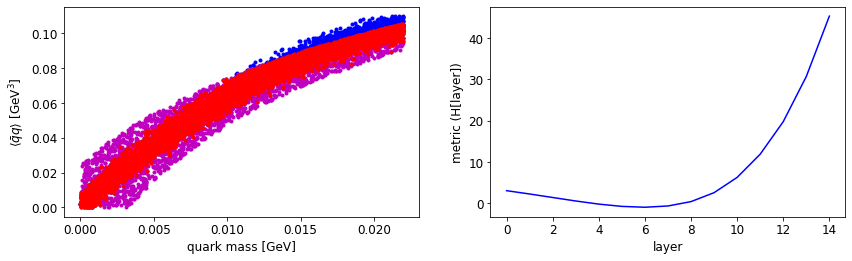

training epoch: 2900,   loss: 0.07583274692296982
lambda: 0.005970820318907499,   AdS radius: 3.7087719440460205[1/GeV]
[ 3.0644116   2.2597926   1.4097507   0.5644186  -0.19158974 -0.742394
 -0.95028186 -0.64487123  0.41518167  2.5781474   6.279145   11.898376
 19.777218   30.719696   45.34408   ]


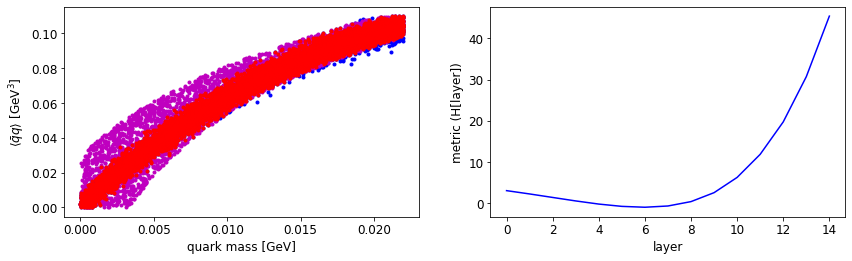

training epoch: 3000,   loss: 0.07616960257291794
lambda: 0.005609090439975262,   AdS radius: 3.698197841644287[1/GeV]
[ 3.0658648   2.2637084   1.4153446   0.56966686 -0.18972646 -0.7460512
 -0.9585089  -0.654133    0.40881076  2.5759068   6.27258    11.869664
 19.728815   30.685106   45.366085  ]


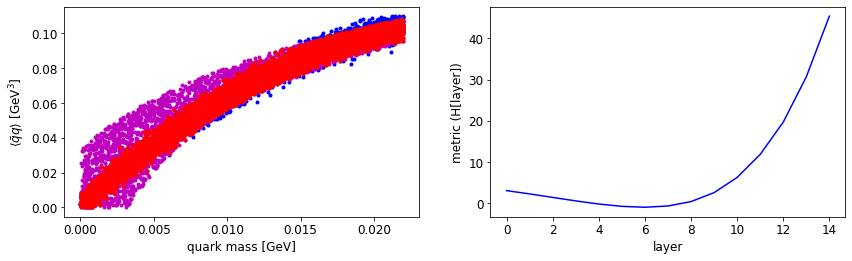

training epoch: 3100,   loss: 0.07494381815195084
lambda: 0.007255894131958485,   AdS radius: 3.7006969451904297[1/GeV]
[ 3.0676167   2.2677677   1.4209934   0.5750793  -0.18740198 -0.7490042
 -0.9660391  -0.66283005  0.40284923  2.5737803   6.2660975  11.843224
 19.686985   30.658895   45.39935   ]


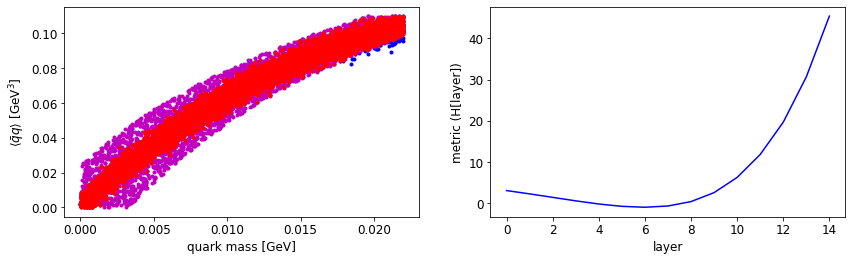

training epoch: 3200,   loss: 0.07623275369405746
lambda: 0.0039297789335250854,   AdS radius: 3.6923153400421143[1/GeV]
[ 3.0731764   2.2753606   1.4300967   0.58408606 -0.18106948 -0.74745816
 -0.96883225 -0.66684693  0.4012997   2.5756264   6.263817   11.823704
 19.656075   30.642902   45.39444   ]


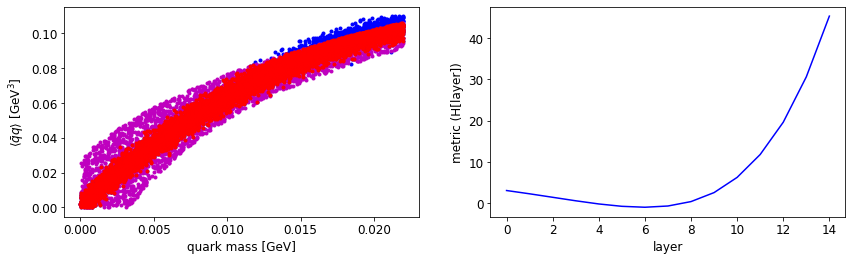

training epoch: 3300,   loss: 0.07572618126869202
lambda: 0.0068274023942649364,   AdS radius: 3.6923558712005615[1/GeV]
[ 3.0746      2.2786608   1.4347644   0.58864987 -0.17902616 -0.75005585
 -0.97582346 -0.6752934   0.39498243  2.5721354   6.255564   11.7983
 19.616451   30.59914    45.317715  ]


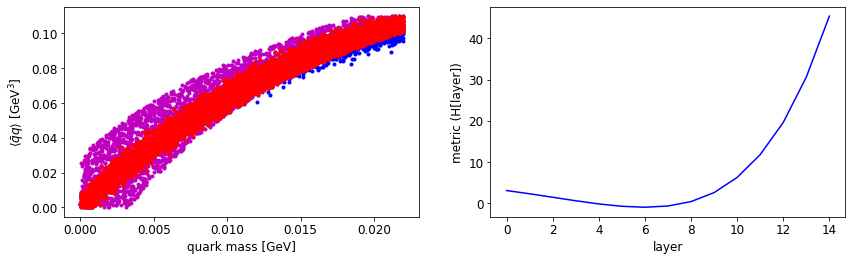

training epoch: 3400,   loss: 0.07552556693553925
lambda: 0.004446480888873339,   AdS radius: 3.7123663425445557[1/GeV]
[ 3.0767586   2.2827208   1.4401846   0.59408    -0.17584865 -0.75121784
 -0.9812294  -0.682131    0.39029124  2.570385    6.2499146  11.779217
 19.591455   30.594225   45.39272   ]


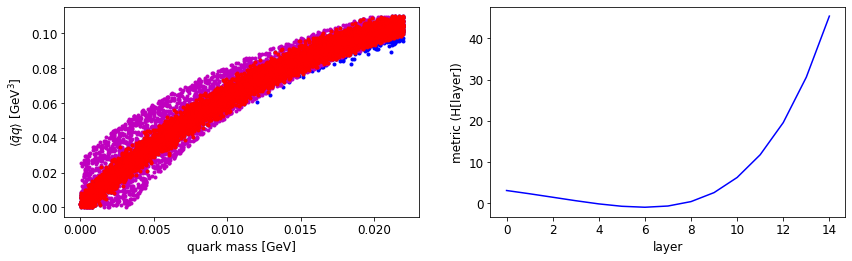

training epoch: 3500,   loss: 0.07532253861427307
lambda: 0.004553027916699648,   AdS radius: 3.7248618602752686[1/GeV]
[ 3.0790577   2.2867177   1.445498    0.5994693  -0.17247835 -0.75188434
 -0.9859843  -0.6883813   0.3859656   2.5686963   6.244553   11.762051
 19.570236   30.591507   45.4283    ]


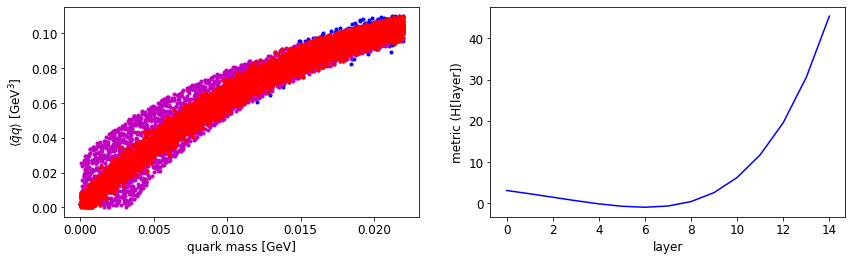

training epoch: 3600,   loss: 0.07572626322507858
lambda: 0.005369334947317839,   AdS radius: 3.7318508625030518[1/GeV]
[ 3.0807729   2.2900584   1.4500723   0.6041574  -0.16963084 -0.75283974
 -0.9909328  -0.6949245   0.38109586  2.5661232   6.238291   11.7448015
 19.548828   30.581356   45.43667   ]


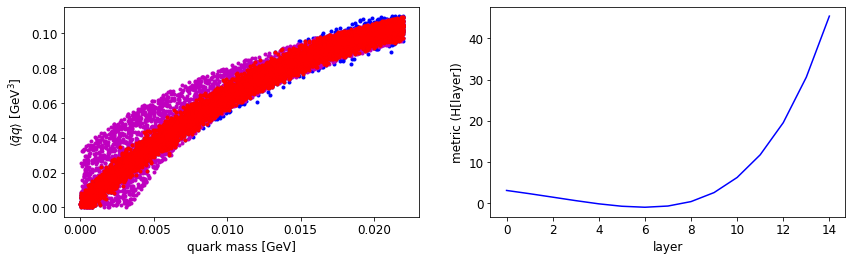

training epoch: 3700,   loss: 0.07495620846748352
lambda: 0.006401178892701864,   AdS radius: 3.7261977195739746[1/GeV]
[ 3.0815995   2.2923927   1.4535888   0.6078336  -0.1676051  -0.7543474
 -0.9962715  -0.70191777  0.37552112  2.5624611   6.2309475  11.727463
 19.526985   30.562906   45.393757  ]


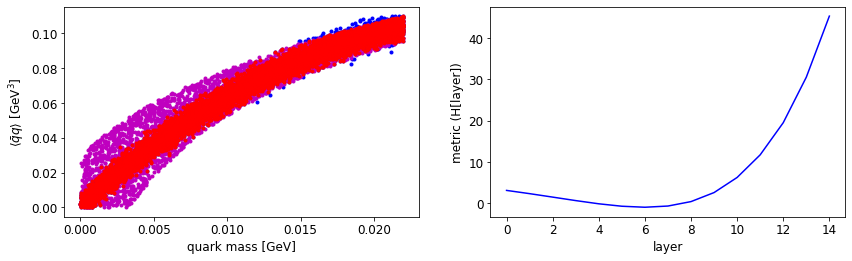

training epoch: 3800,   loss: 0.07488903403282166
lambda: 0.005774703808128834,   AdS radius: 3.728205442428589[1/GeV]
[ 3.0844114   2.2966244   1.4589111   0.613304   -0.16366082 -0.75373125
 -0.9993708  -0.706765    0.37182093  2.5603101   6.2250295  11.711957
 19.50533    30.53652    45.351738  ]


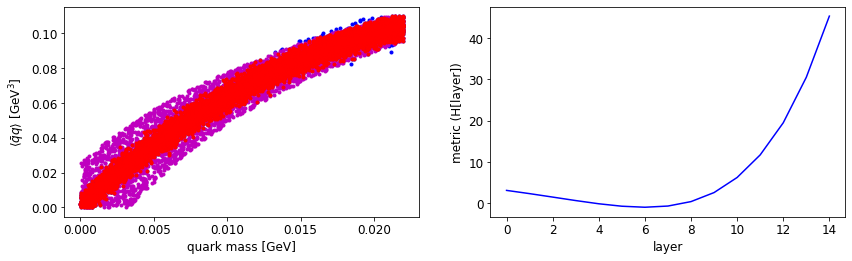

training epoch: 3900,   loss: 0.07631459087133408
lambda: 0.004613060504198074,   AdS radius: 3.7022204399108887[1/GeV]
[ 3.0874386   2.3011782   1.4646301   0.61929876 -0.15896422 -0.752063
 -1.0011958  -0.7102673   0.36940032  2.5594141   6.220991   11.7002
 19.490988   30.52929    45.374794  ]


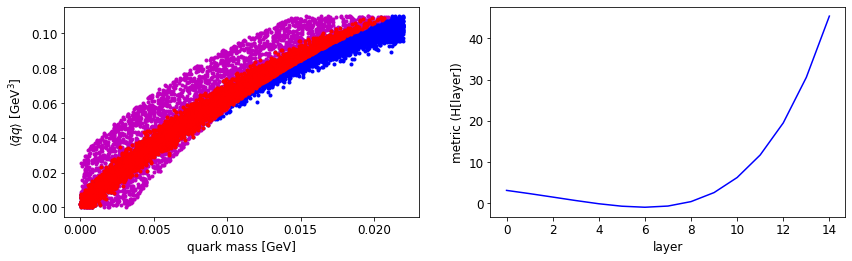

training epoch: 4000,   loss: 0.0775194764137268
lambda: 0.0025625103153288364,   AdS radius: 3.735694646835327[1/GeV]
[ 3.0879698   2.3029358   1.4674077   0.6222724  -0.15731232 -0.75345147
 -1.0061425  -0.71702904  0.36360762  2.5550885   6.2137914  11.686423
 19.476702   30.528921   45.4215    ]


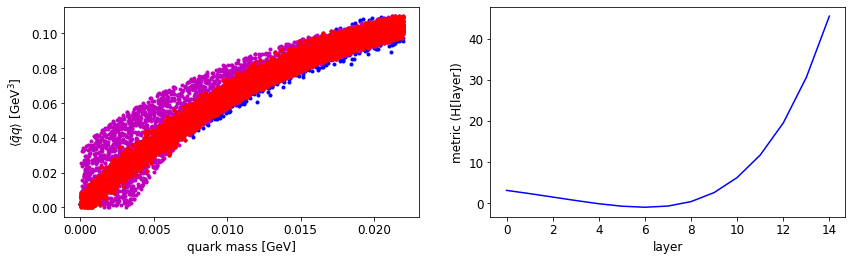

training epoch: 4100,   loss: 0.07495758682489395
lambda: 0.006115573924034834,   AdS radius: 3.7290894985198975[1/GeV]
[ 3.0878801   2.3040206   1.4695308   0.62469643 -0.1559719  -0.7548049
 -1.0107514  -0.7233723   0.35808775  2.550854    6.2070837  11.674447
 19.46563    30.532959   45.45176   ]


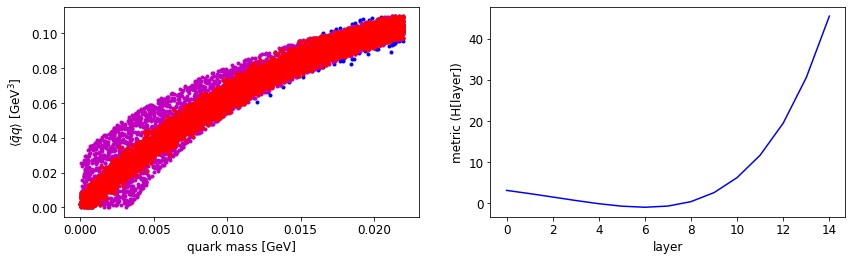

training epoch: 4200,   loss: 0.07644341140985489
lambda: 0.005482284817844629,   AdS radius: 3.7194390296936035[1/GeV]
[ 3.0901675   2.3075435   1.4740543   0.6295343  -0.15212978 -0.75351256
 -1.0126226  -0.72701365  0.3551164   2.5490348   6.202906   11.665622
 19.457993   30.537985   45.481716  ]


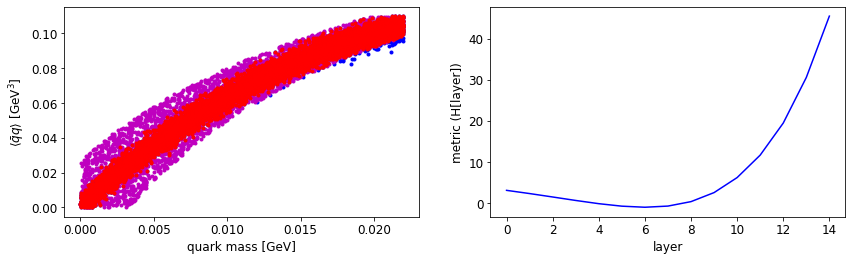

training epoch: 4300,   loss: 0.07600567489862442
lambda: 0.004036801401525736,   AdS radius: 3.7412896156311035[1/GeV]
[ 3.09302     2.3114002   1.4787476   0.6344492  -0.14822866 -0.7521482
 -1.0144428  -0.73076576  0.35177183  2.5464933   6.1977053  11.655171
 19.446104   30.525587   45.44228   ]


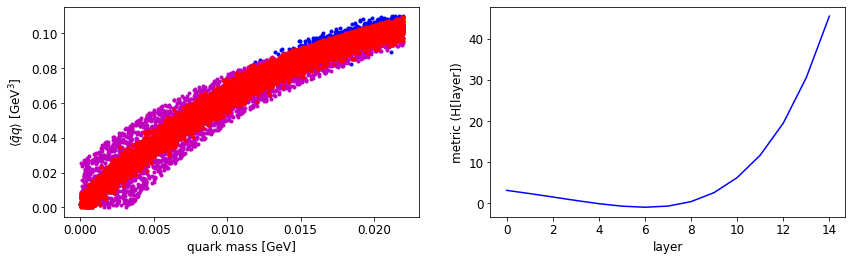

training epoch: 4400,   loss: 0.07513438910245895
lambda: 0.004803731106221676,   AdS radius: 3.7407567501068115[1/GeV]
[ 3.094355    2.313849    1.482119    0.6381456  -0.14535287 -0.7515154
 -1.0167276  -0.7348246   0.3481311   2.5437655   6.1931086  11.647574
 19.44119    30.53577    45.504436  ]


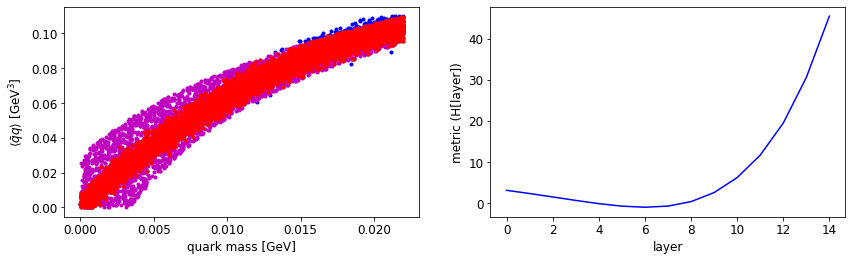

training epoch: 4500,   loss: 0.07493922114372253
lambda: 0.005778022110462189,   AdS radius: 3.7125346660614014[1/GeV]
[ 3.094566    2.3150625   1.4841907   0.64051455 -0.14374085 -0.75200087
 -1.0200007  -0.73993707  0.34313145  2.5391996   6.186135   11.636289
 19.427294   30.514872   45.443314  ]


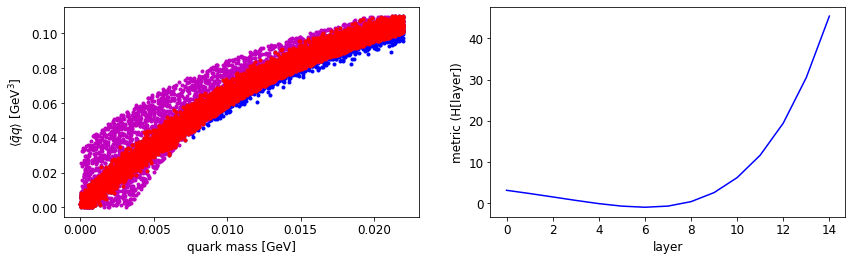

training epoch: 4600,   loss: 0.07522811740636826
lambda: 0.005503308959305286,   AdS radius: 3.7302370071411133[1/GeV]
[ 3.0946002   2.3159575   1.4858234   0.64241594 -0.14260364 -0.7529535
 -1.0237652  -0.74559313  0.33753952  2.5341113   6.179067   11.626065
 19.417238   30.508661   45.441387  ]


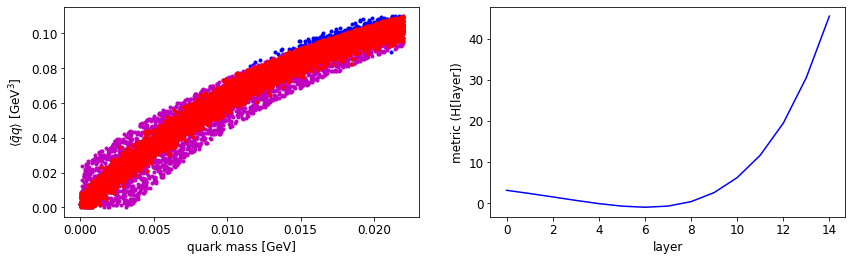

training epoch: 4700,   loss: 0.07673849165439606
lambda: 0.004248116165399551,   AdS radius: 3.709092378616333[1/GeV]
[ 3.099028    2.3214412   1.4921558   0.64909214 -0.13653375 -0.7487427
 -1.0221374  -0.74576026  0.33738825  2.5344303   6.177739   11.622346
 19.414898   30.513962   45.472954  ]


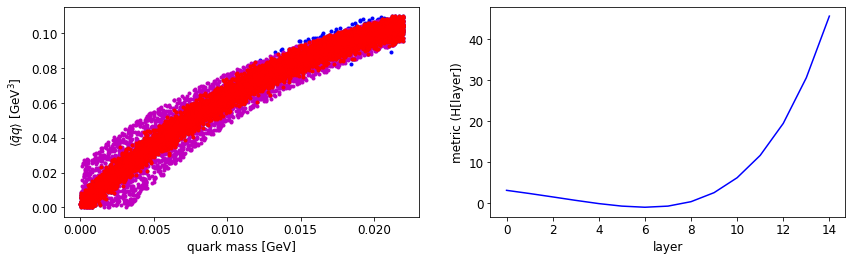

training epoch: 4800,   loss: 0.07606399059295654
lambda: 0.004249691963195801,   AdS radius: 3.7357475757598877[1/GeV]
[ 3.0989904   2.3221908   1.4936872   0.6509581  -0.13523923 -0.7492189
 -1.0250927  -0.7504492   0.3327841   2.5305285   6.1731477  11.617574
 19.417686   30.546024   45.58608   ]


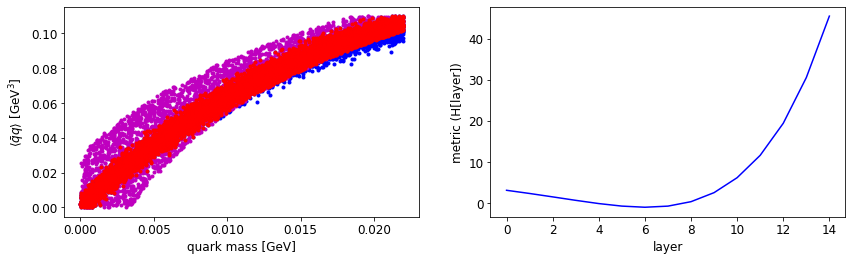

training epoch: 4900,   loss: 0.07612554728984833
lambda: 0.004525826778262854,   AdS radius: 3.7065694332122803[1/GeV]
[ 3.0985472   2.322563    1.4947819   0.65236926 -0.13437234 -0.7500551
 -1.0283862  -0.75561154  0.32731143  2.5251076   6.165895   11.607428
 19.405838   30.525333   45.497643  ]


In [167]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    if epoch<3:
        for (b_phi, b_Pi, b_ans) in batches:
            phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
            loss = Test.loss1(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            train_loss += loss.data[0]
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
    else:
        for (b_phi, b_Pi, b_ans) in batches:
            phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
            loss = Test.loss2(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)